In [1]:
from pathlib import Path
from common.utils import *
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
import csv
import pickle
import os

from dataset.gillam import load_data, load_data_len
from common.time_layers import *
from common.base_model import BaseModel
from common.layers import Affine, SigmoidWithLoss

corpus, word_to_id, id_to_word = load_data('train')

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False


In [2]:
print('train children num:', len(corpus))
print('vocab size:', len(word_to_id))

min_index = np.argmin([len(x) for x in corpus])
max_index = np.argmax([len(x) for x in corpus])
print('min length and index:', len(corpus[min_index]), min_index)
print('max length and index:', len(corpus[max_index]), max_index)


train children num: 540
vocab size: 3721
min length and index: 38 51
max length and index: 1718 467


In [81]:
class Result:
    def __init__(self, train_acc, train_loss, dev_acc, dev_loss, test_acc=None, test_loss=None):
        self.train_acc = train_acc
        self.train_loss = train_loss
        self.dev_acc = dev_acc
        self.dev_loss = dev_loss
        self.test_acc = test_acc
        self.test_loss = test_loss
        self.file_name = None

    def add_result(self, test_acc, test_loss):
        self.test_acc = test_acc
        self.test_loss = test_loss
        self.save_result(self.file_name)

    def save_result(self, file_name=None):
        self.file_name = file_name
        if self.file_name is None:
            self.file_name = self.__class__.__name__ + '.pkl'

        with open(self.file_name, 'wb') as f:
            pickle.dump(self, f)
    def load_result(self):
        if '/' in self.file_name:
            self.file_name = self.file_name.replace('/', os.sep)

        if not os.path.exists(self.file_name):
            raise IOError('No file: ' + self.file_name)

        with open(self.file_name, 'rb') as f:
            result = pickle.load(f)
        return result

    def print_result(self, model_name=None):
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss, label='train loss', color = 'skyblue')
        plt.plot(self.train_acc, label='train acc', color = 'orange')
        plt.axhline(self.test_loss, label='test loss', color = 'skyblue')
        plt.axhline(self.test_acc, label='test acc', color = 'orange')
        plt.ylim(0, 1.5)
        if model_name == None:
            plt.title('train 데이터 결과')
        else:
            plt.title(model_name+' train 데이터 결과')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.dev_loss, label='eval loss', color='skyblue')
        plt.plot(self.dev_acc, label='eval acc', color = 'orange')
        plt.axhline(self.test_loss, label='test loss', color='skyblue')
        plt.axhline(self.test_acc, label='test acc', color = 'orange')
        plt.ylim(0, 1.5)
        if model_name == None:
            plt.title('dev 데이터 결과')
        else:
            plt.title(model_name+' train 데이터 결과')
        plt.legend()
        plt.show()

In [29]:
class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, 1) / 100).astype('f')
        affine_b = np.zeros(1).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio)            
        ]
        self.clf_layer = Affine(affine_W, affine_b)
        self.loss_layer = SigmoidWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
        self.params += self.clf_layer.params
        self.grads += self.clf_layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        try:
            for layer in self.layers:
                # print(layer.name, 'xs shape', xs.shape)
                xs = layer.forward(xs)
        except MemoryError:
            print("MemoryError: xs shape", xs.shape)
        self.last_T = xs.shape[1]
        xs = xs[:,-1,:]
        return xs

    def forward(self, xs, label, train_flg=True):
        xs = self.predict(xs, train_flg)
        score = self.clf_layer.forward(xs)
        # accuracy 구하기
        prob = sigmoid(score)
        y_pred = (prob >= 0.5).astype(int).reshape(-1)
        acc = np.mean(y_pred == label)
        # print(y_pred)            
        # print(score)
        loss = self.loss_layer.forward(score, label)
        # print(loss)
        # print(acc, 'acc')
        return loss, acc

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)    # (N, 1) or (N,) -> (N, 1)
        # print('1 dout shape',dout.shape)
        dout = self.clf_layer.backward(dout)     # (N, 1) -> (N, H)
        # print('2 dout shape',dout.shape)

        # (N, H) -> (N, T, H)로 확장 (마지막 time step에만 gradient)
        N, H = dout.shape
        T = self.last_T
        dxs = np.zeros((N, T, H), dtype=dout.dtype)
        dxs[:, -1, :] = dout   # h_T에만 gradient 전달


        for layer in reversed(self.layers):
            dxs = layer.backward(dxs)
        return dxs

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

#### 첫번째 모델
- 아동의 대화만 분석
- time_size: 48
- 장애 아동의 비율이 높아 Affine계층의 W가 0이 되는 상태 발생 -> W가 0이고, b가 0.5 이상이면 정확도가 0.7~0.8로 나오기 때문
- 해결방안
    - SigmoidWithLoss에 클래스 가중치 추가
    - get_batch에서 장애와 비장애를 같은 양 return

In [28]:
from common.optimizer import Adam
from common.trainer import RnnlmTrainer
from common.utils import eval_loss
import time

batch_size = 32      # 한 번에 학습 할 아동의 수
max_epoch = 30
max_grad = 0.25
wordvec_size = 128    # 단어의 벡터표현 크기
hidden_size = 256    # 문장의 표현 크기
time_size = 48       # 한 번에 읽을 단어 길이
lr = 0.001
dropout = 0.2

corpus_train, word_to_id, id_to_word = load_data_len('train', time_size)
corpus_val_raw, _, _ = load_data_len('dev', time_size)
corpus_val = np.empty(corpus_val_raw.shape[0], dtype=object)
for i in range(corpus_val.shape[0]):
    corpus_val[i] = list(corpus_val_raw[i])
corpus_test, _, _ = load_data_len('test', time_size)

print("train children num", len(corpus_train))
count_TD = 0
count_TD += sum(1 for x in corpus_train if x[-1] == 1)
print("train TD children num", count_TD)
print('train TD cildren ratio', count_TD/len(corpus_train))

vocab_size = len(word_to_id)
label_train = np.array([int(corpus_train[i][-1]) for i in range(len(corpus_train))])
label_val = np.array([int(corpus_val[i][-1]) for i in range(len(corpus_val))])
model_1 = Rnnlm(vocab_size, wordvec_size, hidden_size, dropout)

eval_loss_list = []
eval_acc_list = []

optimizer = Adam(lr)
trainer = RnnlmTrainer(model_1, optimizer)

start_time = time.time()
best_loss = float('inf')

train children num 4502
train TD children num 3506
train TD cildren ratio 0.778764993336295


In [30]:
for epoch in range(max_epoch):

    trainer.fit(corpus_train, label_train, time_size=time_size, hidden_size=hidden_size, max_epoch=1,
                 batch_size=batch_size, max_grad=max_grad, eval_interval=20)
    model_1.reset_state()
    avg_loss, avg_acc = eval_loss(model_1, corpus_val, label_val, batch_size=batch_size, time_size=time_size)
    
    eval_loss_list.append(avg_loss)
    eval_acc_list.append(avg_acc)

    print('평균 loss:', avg_loss)
    print('평균 acc:', avg_acc)
    print('learning rate:', lr)

    if best_loss > avg_loss:
        best_loss = avg_loss
        model_1.save_params('Rnnlm.pkl')
    # else:
    #     lr /= 4.0
    #     optimizer.lr = lr

    model_1.reset_state()
    print('-' * 70)
print('총 학습시간: %d[s]'%(time.time()-start_time))

| 에폭 1 |  반복 20 / 140 | 시간 6[s] | loss 0.6062 | 정확도 0.7766
| 에폭 1 |  반복 40 / 140 | 시간 13[s] | loss 0.5640 | 정확도 0.7609
| 에폭 1 |  반복 60 / 140 | 시간 20[s] | loss 0.5299 | 정확도 0.7844
| 에폭 1 |  반복 80 / 140 | 시간 27[s] | loss 0.4755 | 정확도 0.8203
| 에폭 1 |  반복 100 / 140 | 시간 34[s] | loss 0.5336 | 정확도 0.7766
| 에폭 1 |  반복 120 / 140 | 시간 41[s] | loss 0.5540 | 정확도 0.7594
| 에폭 1 |  반복 140 / 140 | 시간 48[s] | loss 0.5133 | 정확도 0.7937
loss, 정확도 평가 중 ...

평균 loss: 0.49116412
평균 acc: 0.806640625
learning rate: 0.001
----------------------------------------------------------------------
| 에폭 2 |  반복 20 / 140 | 시간 6[s] | loss 0.5148 | 정확도 0.7922
| 에폭 2 |  반복 40 / 140 | 시간 13[s] | loss 0.5067 | 정확도 0.7969
| 에폭 2 |  반복 60 / 140 | 시간 20[s] | loss 0.5305 | 정확도 0.7797
| 에폭 2 |  반복 80 / 140 | 시간 27[s] | loss 0.5302 | 정확도 0.7797
| 에폭 2 |  반복 100 / 140 | 시간 34[s] | loss 0.5267 | 정확도 0.7812
| 에폭 2 |  반복 120 / 140 | 시간 41[s] | loss 0.5005 | 정확도 0.8000
| 에폭 2 |  반복 140 / 140 | 시간 48[s] | loss 0.5884 | 정확도 0.7344
loss

loss, 정확도 평가 중 ...

테스트 loss: 0.5631295
테스트 acc: 0.7916666666666666


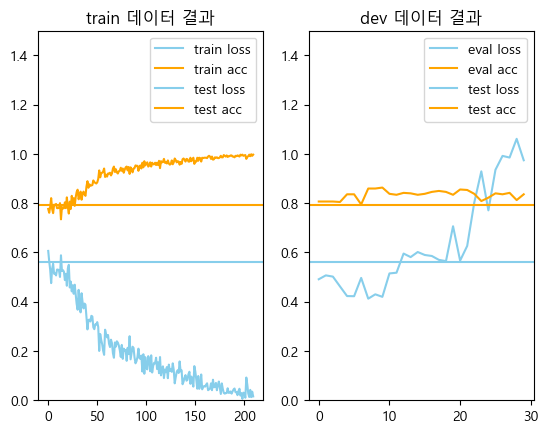

In [31]:
result1 = Result(trainer.acc_list, trainer.lost_list, eval_acc_list, eval_loss_list)
result1.save_result('Rnnlm_result.pkl')
model_1.load_params()
label_test = np.array([int(corpus_test[i][-1]) for i in range(len(corpus_test))])
loss_test_1, acc_test_1 = eval_loss(model_1, corpus_test, label_test, batch_size, time_size)
print('테스트 loss:', loss_test_1)
print('테스트 acc:', acc_test_1)
result1.add_result(acc_test_1, loss_test_1)
result1.print_result()

#### 2. 과적합이 발생한 것으로 추측 → dropout 비율 증가 (0.2 → 0.5) + early stopping 추가

In [32]:
batch_size = 32      # 한 번에 학습 할 아동의 수
max_epoch = 30
max_grad = 0.25
wordvec_size = 128    # 단어의 벡터표현 크기
hidden_size = 256    # 문장의 표현 크기
time_size = 48       # 한 번에 읽을 단어 길이
lr = 0.001
dropout = 0.5

eval_loss_list_2 = []
eval_acc_list_2 = []

model_2 = Rnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = Adam(lr)
trainer = RnnlmTrainer(model_2, optimizer)

start_time = time.time()
best_loss = float('inf')
count = 0
patience = 5

In [33]:
for epoch in range(max_epoch):

    trainer.fit(corpus_train, label_train, time_size=time_size, hidden_size=hidden_size, max_epoch=1,
                 batch_size=batch_size, max_grad=max_grad, eval_interval=20)
    model_2.reset_state()
    avg_loss, avg_acc = eval_loss(model_2, corpus_val, label_val, batch_size=batch_size, time_size=time_size)
    
    eval_loss_list_2.append(avg_loss)
    eval_acc_list_2.append(avg_acc)
        
    print('평균 loss:', avg_loss)
    print('평균 acc:', avg_acc)
    print('learning rate:', lr)

    # 과적합 발생시 early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        count = 0
        model_2.save_params('Rnnlm2.pkl')
    else:
        count += 1

    if count >= patience:
        print('******Early Stopping Triggered******')
        break

    # else:
    #     lr /= 4.0
    #     optimizer.lr = lr

    model_2.reset_state()
    print('-' * 70)
print('총 학습시간: %d[s]'%(time.time()-start_time))

| 에폭 1 |  반복 20 / 140 | 시간 6[s] | loss 0.5943 | 정확도 0.7672
| 에폭 1 |  반복 40 / 140 | 시간 13[s] | loss 0.5531 | 정확도 0.7703
| 에폭 1 |  반복 60 / 140 | 시간 20[s] | loss 0.5349 | 정확도 0.7812
| 에폭 1 |  반복 80 / 140 | 시간 27[s] | loss 0.4916 | 정확도 0.8078
| 에폭 1 |  반복 100 / 140 | 시간 34[s] | loss 0.5513 | 정확도 0.7578
| 에폭 1 |  반복 120 / 140 | 시간 41[s] | loss 0.5097 | 정확도 0.7969
| 에폭 1 |  반복 140 / 140 | 시간 48[s] | loss 0.5497 | 정확도 0.7688
loss, 정확도 평가 중 ...

평균 loss: 0.5006026
평균 acc: 0.806640625
learning rate: 0.001
----------------------------------------------------------------------
| 에폭 2 |  반복 20 / 140 | 시간 6[s] | loss 0.5118 | 정확도 0.7953
| 에폭 2 |  반복 40 / 140 | 시간 13[s] | loss 0.5328 | 정확도 0.7797
| 에폭 2 |  반복 60 / 140 | 시간 20[s] | loss 0.5446 | 정확도 0.7641
| 에폭 2 |  반복 80 / 140 | 시간 27[s] | loss 0.5101 | 정확도 0.7937
| 에폭 2 |  반복 100 / 140 | 시간 34[s] | loss 0.5420 | 정확도 0.7594
| 에폭 2 |  반복 120 / 140 | 시간 41[s] | loss 0.5422 | 정확도 0.7688
| 에폭 2 |  반복 140 / 140 | 시간 47[s] | loss 0.5707 | 정확도 0.7453
loss,

loss, 정확도 평가 중 ...

테스트 loss: 0.51633435
테스트 acc: 0.7875


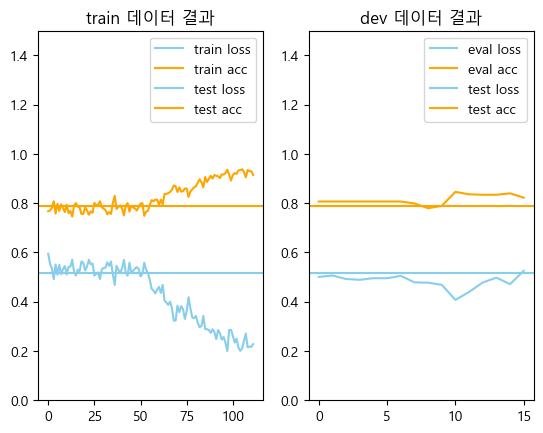

In [34]:
result2 = Result(trainer.acc_list, trainer.lost_list, eval_acc_list_2, eval_loss_list_2)
result2.save_result('Rnnlm2_result.pkl')
model_2.load_params('Rnnlm2.pkl')
label_test = np.array([int(corpus_test[i][-1]) for i in range(len(corpus_test))])
loss_test_2, acc_test_2 = eval_loss(model_2, corpus_test, label_test, batch_size, time_size)
print('테스트 loss:', loss_test_2)
print('테스트 acc:', acc_test_2)
result2.add_result(acc_test_2, loss_test_2)
result2.print_result()

#### 3. 여전히 과적합 존재 → Hidden size 감소

In [63]:
batch_size = 32      # 한 번에 학습 할 아동의 수
max_epoch = 30
max_grad = 0.25
wordvec_size = 128    # 단어의 벡터표현 크기
hidden_size = 128    # 문장의 표현 크기
time_size = 48       # 한 번에 읽을 단어 길이
lr = 0.001
dropout = 0.5

eval_loss_list_3 = []
eval_acc_list_3 = []

model_3 = Rnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = Adam(lr)
trainer = RnnlmTrainer(model_3, optimizer)

start_time = time.time()
best_loss = float('inf')
count = 0
patience = 10

In [64]:
for epoch in range(max_epoch):

    trainer.fit(corpus_train, label_train, time_size=time_size, hidden_size=hidden_size, max_epoch=1,
                 batch_size=batch_size, max_grad=max_grad, eval_interval=20)
    model_3.reset_state()
    avg_loss, avg_acc = eval_loss(model_3, corpus_val, label_val, batch_size=batch_size, time_size=time_size)
    
    eval_loss_list_3.append(avg_loss)
    eval_acc_list_3.append(avg_acc)
        
    print('평균 loss:', avg_loss)
    print('평균 acc:', avg_acc)
    print('learning rate:', lr)

    # 과적합 발생시 early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        count = 0
        model_3.save_params('Rnnlm3.pkl')
    else:
        count += 1

    if count >= patience:
        print('******Early Stopping Triggered******')
        break

    # else:
    #     lr /= 4.0
    #     optimizer.lr = lr

    model_3.reset_state()
    print('-' * 70)
print('총 학습시간: %d[s]'%(time.time()-start_time))

| 에폭 1 |  반복 20 / 140 | 시간 2[s] | loss 0.6465 | 정확도 0.7766
| 에폭 1 |  반복 40 / 140 | 시간 4[s] | loss 0.5381 | 정확도 0.7781
| 에폭 1 |  반복 60 / 140 | 시간 7[s] | loss 0.4718 | 정확도 0.8234
| 에폭 1 |  반복 80 / 140 | 시간 9[s] | loss 0.5501 | 정확도 0.7703
| 에폭 1 |  반복 100 / 140 | 시간 12[s] | loss 0.5574 | 정확도 0.7516
| 에폭 1 |  반복 120 / 140 | 시간 14[s] | loss 0.5287 | 정확도 0.7797
| 에폭 1 |  반복 140 / 140 | 시간 17[s] | loss 0.5538 | 정확도 0.7672
loss, 정확도 평가 중 ...

평균 loss: 0.49831897
평균 acc: 0.806640625
learning rate: 0.001
----------------------------------------------------------------------
| 에폭 2 |  반복 20 / 140 | 시간 2[s] | loss 0.5414 | 정확도 0.7703
| 에폭 2 |  반복 40 / 140 | 시간 4[s] | loss 0.4785 | 정확도 0.8203
| 에폭 2 |  반복 60 / 140 | 시간 7[s] | loss 0.5410 | 정확도 0.7719
| 에폭 2 |  반복 80 / 140 | 시간 9[s] | loss 0.5302 | 정확도 0.7844
| 에폭 2 |  반복 100 / 140 | 시간 12[s] | loss 0.5079 | 정확도 0.7984
| 에폭 2 |  반복 120 / 140 | 시간 14[s] | loss 0.5238 | 정확도 0.7844
| 에폭 2 |  반복 140 / 140 | 시간 16[s] | loss 0.5387 | 정확도 0.7688
loss, 정확도 

loss, 정확도 평가 중 ...

테스트 loss: 0.5273255
테스트 acc: 0.7791666666666667


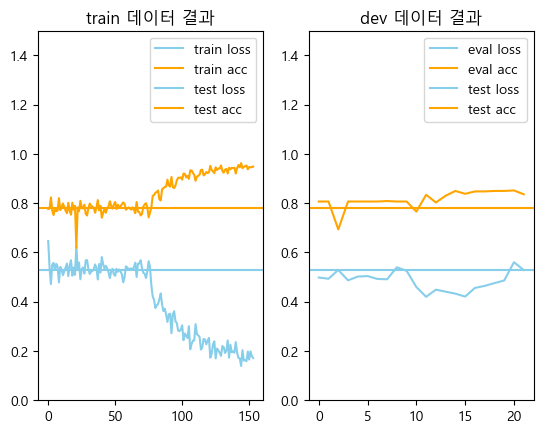

In [65]:
result3 = Result(trainer.acc_list, trainer.lost_list, eval_acc_list_3, eval_loss_list_3)
result3.save_result('Rnnlm3_result.pkl')
model_3.load_params('Rnnlm3.pkl')
loss_test_3, acc_test_3 = eval_loss(model_3, corpus_test, label_test, batch_size, time_size)
print('테스트 loss:', loss_test_3)
print('테스트 acc:', acc_test_3)
result3.add_result(acc_test_3, loss_test_3)
result3.print_result()

#### 4. Hidden Size와 Wordvec Size, lr 감소
- size가 줄어 계산속도가 상승했기때문에 max_epoch 증가
- early stop의 조건 변경

In [38]:
batch_size = 32      # 한 번에 학습 할 아동의 수
max_epoch = 3000
max_grad = 0.25
wordvec_size = 32    # 단어의 벡터표현 크기
hidden_size = 16    # 문장의 표현 크기
time_size = 48       # 한 번에 읽을 단어 길이
lr = 0.00005
dropout = 0.5

eval_loss_list_4 = []
eval_acc_list_4 = []

model_4 = Rnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = Adam(lr)
trainer = RnnlmTrainer(model_4, optimizer)

start_time = time.time()
best_loss = float('inf')
count = 0
patience = 10

In [39]:
for epoch in range(max_epoch):

    trainer.fit(corpus_train, label_train, time_size=time_size, hidden_size=hidden_size, max_epoch=1,
                 batch_size=batch_size, max_grad=max_grad, eval_interval=20)
    model_4.reset_state()
    avg_loss, avg_acc = eval_loss(model_4, corpus_val, label_val, batch_size=batch_size, time_size=time_size)
    
    eval_loss_list_4.append(avg_loss)
    eval_acc_list_4.append(avg_acc)
        
    print('평균 loss:', avg_loss)
    print('평균 acc:', avg_acc)
    print('learning rate:', lr)

    # 과적합 발생시 early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        count = 0
        model_4.save_params('Rnnlm4.pkl')

    if (avg_loss - trainer.lost_list[-1]) >= 0.1:
        print('******Early Stopping Triggered******')
        break

    model_4.reset_state()
    print('-' * 70)
print('총 학습시간: %d[s]'%(time.time()-start_time))

| 에폭 1 |  반복 20 / 140 | 시간 0[s] | loss 0.6930 | 정확도 0.7328
| 에폭 1 |  반복 40 / 140 | 시간 1[s] | loss 0.6928 | 정확도 0.7547
| 에폭 1 |  반복 60 / 140 | 시간 1[s] | loss 0.6924 | 정확도 0.7984
| 에폭 1 |  반복 80 / 140 | 시간 2[s] | loss 0.6920 | 정확도 0.8078
| 에폭 1 |  반복 100 / 140 | 시간 2[s] | loss 0.6918 | 정확도 0.7656
| 에폭 1 |  반복 120 / 140 | 시간 3[s] | loss 0.6915 | 정확도 0.7641
| 에폭 1 |  반복 140 / 140 | 시간 3[s] | loss 0.6909 | 정확도 0.7922
loss, 정확도 평가 중 ...

평균 loss: 0.69050497
평균 acc: 0.806640625
learning rate: 5e-05
----------------------------------------------------------------------
| 에폭 2 |  반복 20 / 140 | 시간 0[s] | loss 0.6905 | 정확도 0.7781
| 에폭 2 |  반복 40 / 140 | 시간 1[s] | loss 0.6901 | 정확도 0.7703
| 에폭 2 |  반복 60 / 140 | 시간 1[s] | loss 0.6892 | 정확도 0.7969
| 에폭 2 |  반복 80 / 140 | 시간 2[s] | loss 0.6889 | 정확도 0.7703
| 에폭 2 |  반복 100 / 140 | 시간 2[s] | loss 0.6876 | 정확도 0.8000
| 에폭 2 |  반복 120 / 140 | 시간 3[s] | loss 0.6873 | 정확도 0.7672
| 에폭 2 |  반복 140 / 140 | 시간 3[s] | loss 0.6859 | 정확도 0.7766
loss, 정확도 평가 중 .

loss, 정확도 평가 중 ...

테스트 loss: 0.50147104
테스트 acc: 0.7979166666666667


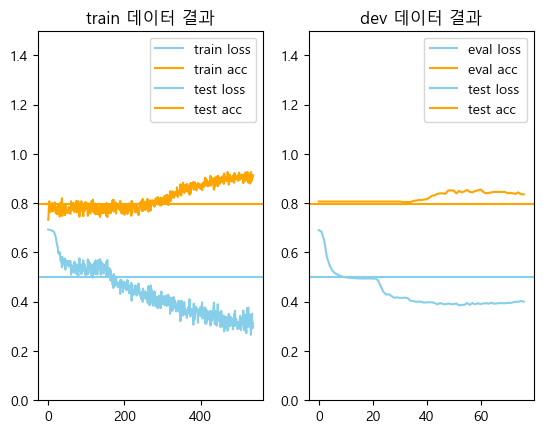

In [40]:
result4 = Result(trainer.acc_list, trainer.lost_list, eval_acc_list_4, eval_loss_list_4)
result4.save_result('Rnnlm4_result.pkl')
loss_test_4, acc_test_4 = eval_loss(model_4, corpus_test, label_test, batch_size, time_size)
print('테스트 loss:', loss_test_4)
print('테스트 acc:', acc_test_4)
result4.add_result(acc_test_4, loss_test_4)
result4.print_result()

#### 5. 표현력을 줄이기 위해 LSTM을 1층으로 수정
- 새로운 모델이기때문에 과적합의 발생 유무를 보기 위해 early stopping 삭제

In [41]:
class SimpleRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, 1) / 100).astype('f')
        affine_b = np.zeros(1).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio)            
        ]
        self.clf_layer = Affine(affine_W, affine_b)
        self.loss_layer = SigmoidWithLoss()
        self.lstm_layer = self.layers[2]
        self.drop_layers = [self.layers[1], self.layers[3]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
        self.params += self.clf_layer.params
        self.grads += self.clf_layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        try:
            for layer in self.layers:
                xs = layer.forward(xs)
        except MemoryError:
            print("MemoryError: xs shape", xs.shape)
        self.last_T = xs.shape[1]
        xs = xs[:,-1,:]
        return xs

    def forward(self, xs, label, train_flg=True):
        xs = self.predict(xs, train_flg)
        score = self.clf_layer.forward(xs)
        # accuracy 구하기
        prob = sigmoid(score)
        y_pred = (prob >= 0.5).astype(int).reshape(-1)
        acc = np.mean(y_pred == label)
        loss = self.loss_layer.forward(score, label)
        return loss, acc

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)    # (N, 1) or (N,) -> (N, 1)
        dout = self.clf_layer.backward(dout)     # (N, 1) -> (N, H)

        # (N, H) -> (N, T, H)로 확장 (마지막 time step에만 gradient)
        N, H = dout.shape
        T = self.last_T
        dxs = np.zeros((N, T, H), dtype=dout.dtype)
        dxs[:, -1, :] = dout   # h_T에만 gradient 전달


        for layer in reversed(self.layers):
            dxs = layer.backward(dxs)
        return dxs

    def reset_state(self):
        self.lstm_layer.reset_state()

In [ ]:
batch_size = 32      # 한 번에 학습 할 아동의 수
max_epoch = 400
max_grad = 0.25
wordvec_size = 32    # 단어의 벡터표현 크기
hidden_size = 16    # 문장의 표현 크기
time_size = 48       # 한 번에 읽을 단어 길이
lr = 0.00001
dropout = 0.5

eval_loss_list_5 = []
eval_acc_list_5 = []

model_5 = SimpleRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = Adam(lr)
trainer = RnnlmTrainer(model_5, optimizer)

start_time = time.time()
best_loss = float('inf')
count = 0
patience = 10

In [48]:
for epoch in range(max_epoch):

    trainer.fit(corpus_train, label_train, time_size=time_size, hidden_size=hidden_size, max_epoch=1,
                 batch_size=batch_size, max_grad=max_grad, eval_interval=20)
    model_5.reset_state()
    avg_loss, avg_acc = eval_loss(model_5, corpus_val, label_val, batch_size=batch_size, time_size=time_size)
    
    eval_loss_list_5.append(avg_loss)
    eval_acc_list_5.append(avg_acc)
        
    print('평균 loss:', avg_loss)
    print('평균 acc:', avg_acc)
    print('learning rate:', lr)

    # 과적합 발생시 early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        count = 0
        model_5.save_params('SimpleRnnlm.pkl')
    else:
        count += 1

    if count >= patience:
        print('******Early Stopping Triggered******')
        break

    model_5.reset_state()
    print('-' * 70)
print('총 학습시간: %d[s]'%(time.time()-start_time))

| 에폭 1 |  반복 20 / 140 | 시간 0[s] | loss 0.6931 | 정확도 0.5844
| 에폭 1 |  반복 40 / 140 | 시간 0[s] | loss 0.6931 | 정확도 0.7578
| 에폭 1 |  반복 60 / 140 | 시간 1[s] | loss 0.6930 | 정확도 0.7703
| 에폭 1 |  반복 80 / 140 | 시간 1[s] | loss 0.6929 | 정확도 0.8109
| 에폭 1 |  반복 100 / 140 | 시간 1[s] | loss 0.6929 | 정확도 0.7766
| 에폭 1 |  반복 120 / 140 | 시간 2[s] | loss 0.6929 | 정확도 0.7531
| 에폭 1 |  반복 140 / 140 | 시간 2[s] | loss 0.6927 | 정확도 0.8000
loss, 정확도 평가 중 ...

평균 loss: 0.6926826
평균 acc: 0.806640625
learning rate: 1e-05
----------------------------------------------------------------------
| 에폭 2 |  반복 20 / 140 | 시간 0[s] | loss 0.6927 | 정확도 0.7766
| 에폭 2 |  반복 40 / 140 | 시간 0[s] | loss 0.6926 | 정확도 0.8063
| 에폭 2 |  반복 60 / 140 | 시간 1[s] | loss 0.6926 | 정확도 0.7719
| 에폭 2 |  반복 80 / 140 | 시간 1[s] | loss 0.6926 | 정확도 0.7531
| 에폭 2 |  반복 100 / 140 | 시간 1[s] | loss 0.6924 | 정확도 0.7953
| 에폭 2 |  반복 120 / 140 | 시간 2[s] | loss 0.6924 | 정확도 0.7734
| 에폭 2 |  반복 140 / 140 | 시간 2[s] | loss 0.6923 | 정확도 0.7750
loss, 정확도 평가 중 ..

loss, 정확도 평가 중 ...

테스트 loss: 0.4869651
테스트 acc: 0.7791666666666667


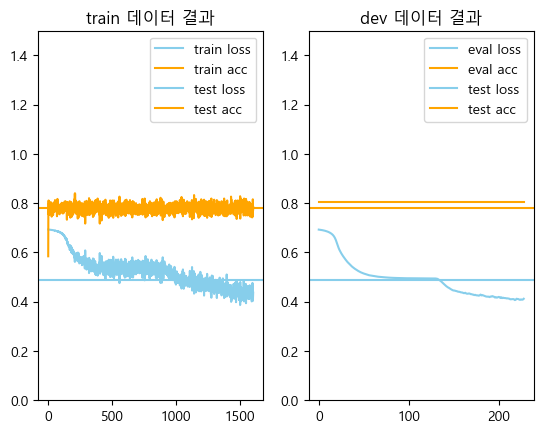

In [49]:
result5 = Result(trainer.acc_list, trainer.lost_list, eval_acc_list_5, eval_loss_list_5)
result5.save_result('SimpleRnnlm_result.pkl')
model_5.load_params('SimpleRnnlm.pkl')
loss_test_5, acc_test_5 = eval_loss(model_5, corpus_test, label_test, batch_size, time_size)
print('테스트 loss:', loss_test_5)
print('테스트 acc:', acc_test_5)
result5.add_result(acc_test_5, loss_test_5)
result5.print_result()

#### 5개 모델의 test 결과

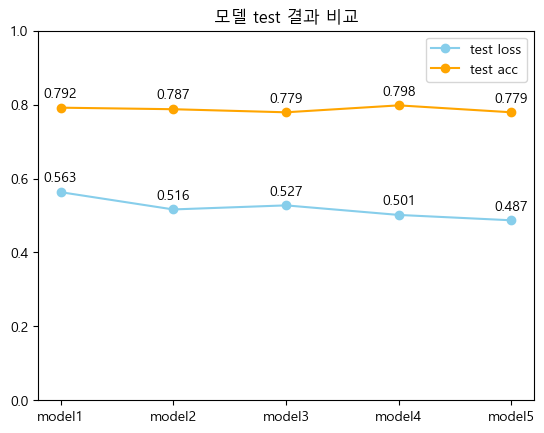

In [77]:
test_loss_list = np.array([loss_test_1, loss_test_2, loss_test_3, loss_test_4, loss_test_5])
test_acc_list = np.array([acc_test_1, acc_test_2, acc_test_3, acc_test_4, acc_test_5])
index = np.arange(len(test_acc_list))

plt.plot(test_loss_list, color = 'skyblue', label = 'test loss', marker='o')
plt.plot(test_acc_list, color = 'orange', label = 'test acc', marker='o')
plt.legend()
plt.ylim(0, 1)
plt.xticks(index, ['model1', 'model2', 'model3', 'model4', 'model5'])
plt.title('모델 test 결과 비교')

for i in index:
    plt.text(index[i], test_loss_list[i]+0.02, '%.3f' %test_loss_list[i], ha='center', va='bottom')
    plt.text(index[i], test_acc_list[i]+0.02, '%.3f' %test_acc_list[i], ha='center', va='bottom')
plt.show()

#### 6. 클래스 불균형 해결을 위해 Weighted Sigmoid Loss 함수 사용

In [ ]:
class WeightedRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, 1) / 100).astype('f')
        affine_b = np.zeros(1).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),         
        ]
        self.clf_layer = Affine(affine_W, affine_b)
        self.loss_layer = WeightedSigmoidWithLoss(pos_weight=1.0, neg_weight=3.0)
        self.lstm_layer = self.layers[2]
        self.drop_layers = [self.layers[1], self.layers[3]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        self.params += self.clf_layer.params
        self.grads += self.clf_layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        try:
            for layer in self.layers:
                xs = layer.forward(xs)
        except MemoryError:
            print("MemoryError: xs shape", xs.shape)
        self.last_T = xs.shape[1]
        xs = xs[:,-1,:]
        return xs

    def forward(self, xs, label, train_flg=True):
        xs = self.predict(xs, train_flg)
        score = self.clf_layer.forward(xs)
        prob = sigmoid(score)
        y_pred = (prob >= 0.5).astype(int).reshape(-1)
        acc = np.mean(y_pred == label)
        loss = self.loss_layer.forward(score, label)
        return loss, acc

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)    # (N, 1) or (N,) -> (N, 1)
        dout = self.clf_layer.backward(dout)     # (N, 1) -> (N, H)

        # (N, H) -> (N, T, H)로 확장 (마지막 time step에만 gradient)
        N, H = dout.shape
        T = self.last_T
        dxs = np.zeros((N, T, H), dtype=dout.dtype)
        dxs[:, -1, :] = dout   # h_T에만 gradient 전달

        for layer in reversed(self.layers):
            dxs = layer.backward(dxs)
        return dxs

    def reset_state(self):
        self.lstm_layer.reset_state()


In [52]:
eval_loss_list_6 = []
eval_acc_list_6 = []

model_6 = WeightedRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = Adam(lr)
trainer = RnnlmTrainer(model_6, optimizer)

start_time = time.time()
best_loss = float('inf')
count = 0
patience = 20

for epoch in range(max_epoch):

    trainer.fit(corpus_train, label_train, time_size=time_size, hidden_size=hidden_size, max_epoch=1,
                 batch_size=batch_size, max_grad=max_grad, eval_interval=20)
    model_6.reset_state()
    avg_loss, avg_acc = eval_loss(model_6, corpus_val, label_val, batch_size=batch_size, time_size=time_size)
    
    eval_loss_list_6.append(avg_loss)
    eval_acc_list_6.append(avg_acc)
        
    print('평균 loss:', avg_loss)
    print('평균 acc:', avg_acc)
    print('learning rate:', lr)

    # 과적합 발생시 early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        count = 0
        model_6.save_params('WeigtedRnnlm.pkl')
    else:
        count += 1

    if count >= patience:
        print('******Early Stopping Triggered******')
        break

    model_6.reset_state()
    print('-' * 70)
print('총 학습시간: %d[s]'%(time.time()-start_time))


| 에폭 1 |  반복 20 / 140 | 시간 0[s] | loss 0.6932 | 정확도 0.4891
| 에폭 1 |  반복 40 / 140 | 시간 0[s] | loss 0.6931 | 정확도 0.5828
| 에폭 1 |  반복 60 / 140 | 시간 1[s] | loss 0.6931 | 정확도 0.6391
| 에폭 1 |  반복 80 / 140 | 시간 1[s] | loss 0.6931 | 정확도 0.7047
| 에폭 1 |  반복 100 / 140 | 시간 2[s] | loss 0.6931 | 정확도 0.6953
| 에폭 1 |  반복 120 / 140 | 시간 2[s] | loss 0.6930 | 정확도 0.7438
| 에폭 1 |  반복 140 / 140 | 시간 2[s] | loss 0.6930 | 정확도 0.7594
loss, 정확도 평가 중 ...

평균 loss: 0.6929608
평균 acc: 0.806640625
learning rate: 1e-05
----------------------------------------------------------------------
| 에폭 2 |  반복 20 / 140 | 시간 0[s] | loss 0.6929 | 정확도 0.8031
| 에폭 2 |  반복 40 / 140 | 시간 0[s] | loss 0.6929 | 정확도 0.8047
| 에폭 2 |  반복 60 / 140 | 시간 1[s] | loss 0.6929 | 정확도 0.8016
| 에폭 2 |  반복 80 / 140 | 시간 1[s] | loss 0.6928 | 정확도 0.7906
| 에폭 2 |  반복 100 / 140 | 시간 2[s] | loss 0.6928 | 정확도 0.7734
| 에폭 2 |  반복 120 / 140 | 시간 2[s] | loss 0.6928 | 정확도 0.7594
| 에폭 2 |  반복 140 / 140 | 시간 2[s] | loss 0.6927 | 정확도 0.7969
loss, 정확도 평가 중 ..

loss, 정확도 평가 중 ...

테스트 loss: 0.48844287
테스트 acc: 0.7604166666666666


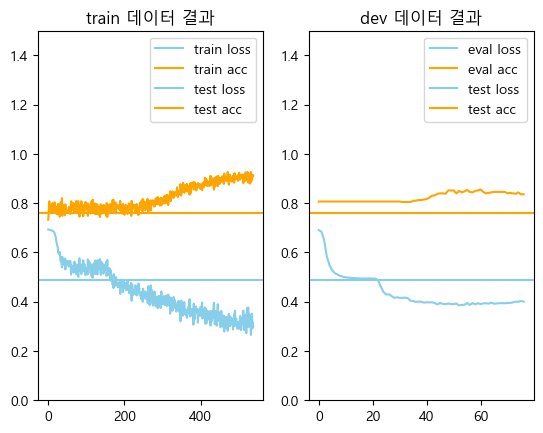

In [53]:
result6 = Result(trainer.acc_list, trainer.lost_list, eval_acc_list_6, eval_loss_list_6)
result6.save_result('WeigtedRnnlm_result.pkl')
model_6.load_params('WeigtedRnnlm.pkl')
loss_test_6, acc_test_6 = eval_loss(model_6, corpus_test, label_test, batch_size, time_size)
print('테스트 loss:', loss_test_6)
print('테스트 acc:', acc_test_6)
result4.add_result(acc_test_6, loss_test_6)
result4.print_result()

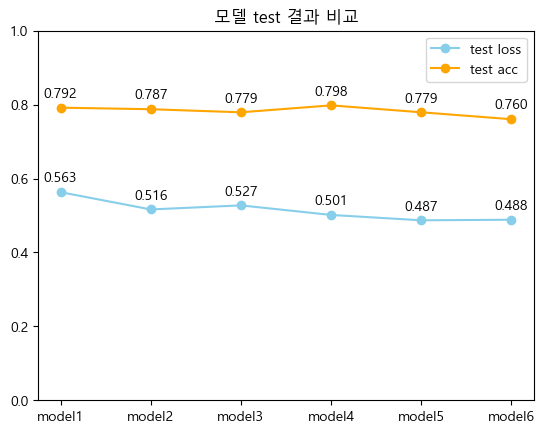

In [78]:
test_loss_list = np.append(test_loss_list, loss_test_6)
test_acc_list = np.append(test_acc_list, acc_test_6)
index = np.arange(len(test_acc_list))

plt.plot(test_loss_list, color = 'skyblue', label = 'test loss', marker='o')
plt.plot(test_acc_list, color = 'orange', label = 'test acc', marker='o')
plt.legend()
plt.ylim(0, 1)
plt.xticks(index, ['model1', 'model2', 'model3', 'model4', 'model5', 'model6'])
plt.title('모델 test 결과 비교')

for i in index:
    plt.text(index[i], test_loss_list[i]+0.02, '%.3f' %test_loss_list[i], ha='center', va='bottom')
    plt.text(index[i], test_acc_list[i]+0.02, '%.3f' %test_acc_list[i], ha='center', va='bottom')
plt.show()

#### Hidden state에서 마지막 state만 사용 → Pooling 사용

In [61]:
class PoolingSimpleRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, 1) / 100).astype('f')
        affine_b = np.zeros(1).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio)            
        ]
        self.clf_layer = Affine(affine_W, affine_b)
        self.loss_layer = SigmoidWithLoss()
        self.lstm_layer = self.layers[2]
        self.drop_layers = [self.layers[1], self.layers[3]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
        self.params += self.clf_layer.params
        self.grads += self.clf_layer.grads

    def predict(self, xs, train_flg=False, mode=None):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        try:
            for layer in self.layers:
                xs = layer.forward(xs)
        except MemoryError:
            print("MemoryError: xs shape", xs.shape)
        self.last_T = xs.shape[1]
        # 수정 부분
        match mode:
            case 'mean' | 'Mean':
                xs = np.mean(xs, axis=1)    
            case 'max' | 'Max':
                xs = np.max(xs, axis=1) 
            case 'min' | 'Min':
                xs = np.min(xs, axis=1) 
            case _:
                xs = xs[:, -1, :] 
        return xs

    def forward(self, xs, label, train_flg=True, mode=None):
        # 수정 부분
        xs = self.predict(xs, train_flg, mode)
        score = self.clf_layer.forward(xs)
        # accuracy 구하기
        prob = sigmoid(score)
        y_pred = (prob >= 0.5).astype(int).reshape(-1)
        acc = np.mean(y_pred == label)
        loss = self.loss_layer.forward(score, label)
        return loss, acc

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)    # (N, 1) or (N,) -> (N, 1)
        dout = self.clf_layer.backward(dout)     # (N, 1) -> (N, H)

        # (N, H) -> (N, T, H)로 확장 (마지막 time step에만 gradient)
        N, H = dout.shape
        T = self.last_T
        dxs = np.zeros((N, T, H), dtype=dout.dtype)
        dxs[:, -1, :] = dout   # h_T에만 gradient 전달


        for layer in reversed(self.layers):
            dxs = layer.backward(dxs)
        return dxs

    def reset_state(self):
        self.lstm_layer.reset_state()

In [62]:
from common.trainer import PoolingRnnlmTrainer

eval_loss_list_7 = []
eval_acc_list_7 = []

model_7 = PoolingSimpleRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = Adam(lr)
trainer = PoolingRnnlmTrainer(model_7, optimizer, 'mean')

start_time = time.time()
best_loss = float('inf')
count = 0
patience = 20

for epoch in range(max_epoch):

    trainer.fit(corpus_train, label_train, time_size=time_size, hidden_size=hidden_size, max_epoch=1,
                 batch_size=batch_size, max_grad=max_grad, eval_interval=20)
    model_7.reset_state()
    avg_loss, avg_acc = eval_loss(model_7, corpus_val, label_val, batch_size=batch_size, time_size=time_size)
    
    eval_loss_list_7.append(avg_loss)
    eval_acc_list_7.append(avg_acc)
        
    print('평균 loss:', avg_loss)
    print('평균 acc:', avg_acc)
    print('learning rate:', lr)

    # 과적합 발생시 early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        count = 0
        model_7.save_params('PooingSimpleRnnlm.pkl')
    else:
        count += 1

    if count >= patience:
        print('******Early Stopping Triggered******')
        break

    model_7.reset_state()
    print('-' * 70)
print('총 학습시간: %d[s]'%(time.time()-start_time))

| 에폭 1 |  반복 20 / 140 | 시간 0[s] | loss 0.6931 | 정확도 0.5344
| 에폭 1 |  반복 40 / 140 | 시간 0[s] | loss 0.6931 | 정확도 0.7016
| 에폭 1 |  반복 60 / 140 | 시간 1[s] | loss 0.6930 | 정확도 0.7469
| 에폭 1 |  반복 80 / 140 | 시간 1[s] | loss 0.6930 | 정확도 0.7375
| 에폭 1 |  반복 100 / 140 | 시간 2[s] | loss 0.6929 | 정확도 0.7844
| 에폭 1 |  반복 120 / 140 | 시간 2[s] | loss 0.6929 | 정확도 0.7531
| 에폭 1 |  반복 140 / 140 | 시간 2[s] | loss 0.6928 | 정확도 0.7750
loss, 정확도 평가 중 ...

평균 loss: 0.69266796
평균 acc: 0.806640625
learning rate: 1e-05
----------------------------------------------------------------------
| 에폭 2 |  반복 20 / 140 | 시간 0[s] | loss 0.6927 | 정확도 0.7703
| 에폭 2 |  반복 40 / 140 | 시간 0[s] | loss 0.6926 | 정확도 0.8000
| 에폭 2 |  반복 60 / 140 | 시간 1[s] | loss 0.6925 | 정확도 0.7812
| 에폭 2 |  반복 80 / 140 | 시간 1[s] | loss 0.6925 | 정확도 0.7531
| 에폭 2 |  반복 100 / 140 | 시간 1[s] | loss 0.6924 | 정확도 0.7750
| 에폭 2 |  반복 120 / 140 | 시간 2[s] | loss 0.6923 | 정확도 0.7719
| 에폭 2 |  반복 140 / 140 | 시간 2[s] | loss 0.6922 | 정확도 0.7969
loss, 정확도 평가 중 .

In [72]:
eval_loss_list_8 = []
eval_acc_list_8 = []

batch_size = 32      # 한 번에 학습 할 아동의 수
max_epoch = 400
max_grad = 0.25
wordvec_size = 32    # 단어의 벡터표현 크기
hidden_size = 16    # 문장의 표현 크기
time_size = 48       # 한 번에 읽을 단어 길이
lr = 0.00001
dropout = 0.5

model_8 = PoolingSimpleRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = Adam(lr)
trainer = PoolingRnnlmTrainer(model_8, optimizer, 'max')

start_time = time.time()
best_loss = float('inf')
count = 0
patience = 20

for epoch in range(max_epoch):

    trainer.fit(corpus_train, label_train, time_size=time_size, hidden_size=hidden_size, max_epoch=1,
                 batch_size=batch_size, max_grad=max_grad, eval_interval=20)
    model_8.reset_state()
    avg_loss, avg_acc = eval_loss(model_8, corpus_val, label_val, batch_size=batch_size, time_size=time_size)
    
    eval_loss_list_8.append(avg_loss)
    eval_acc_list_8.append(avg_acc)
        
    print('평균 loss:', avg_loss)
    print('평균 acc:', avg_acc)
    print('learning rate:', lr)

    # 과적합 발생시 early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        count = 0
        model_8.save_params('PooingSimpleRnnlm2.pkl')
    else:
        count += 1

    if count >= patience:
        print('******Early Stopping Triggered******')
        break

    model_7.reset_state()
    print('-' * 70)
print('총 학습시간: %d[s]'%(time.time()-start_time))

| 에폭 1 |  반복 20 / 140 | 시간 0[s] | loss 0.6931 | 정확도 0.5766
| 에폭 1 |  반복 40 / 140 | 시간 0[s] | loss 0.6930 | 정확도 0.7406
| 에폭 1 |  반복 60 / 140 | 시간 1[s] | loss 0.6930 | 정확도 0.7781
| 에폭 1 |  반복 80 / 140 | 시간 1[s] | loss 0.6929 | 정확도 0.7891
| 에폭 1 |  반복 100 / 140 | 시간 1[s] | loss 0.6928 | 정확도 0.7781
| 에폭 1 |  반복 120 / 140 | 시간 2[s] | loss 0.6927 | 정확도 0.8000
| 에폭 1 |  반복 140 / 140 | 시간 2[s] | loss 0.6927 | 정확도 0.7859
loss, 정확도 평가 중 ...

평균 loss: 0.69263524
평균 acc: 0.806640625
learning rate: 1e-05
----------------------------------------------------------------------
| 에폭 2 |  반복 20 / 140 | 시간 0[s] | loss 0.6926 | 정확도 0.7953
| 에폭 2 |  반복 40 / 140 | 시간 0[s] | loss 0.6925 | 정확도 0.7937
| 에폭 2 |  반복 60 / 140 | 시간 1[s] | loss 0.6924 | 정확도 0.8047
| 에폭 2 |  반복 80 / 140 | 시간 1[s] | loss 0.6925 | 정확도 0.7609
| 에폭 2 |  반복 100 / 140 | 시간 1[s] | loss 0.6924 | 정확도 0.7641
| 에폭 2 |  반복 120 / 140 | 시간 2[s] | loss 0.6923 | 정확도 0.7719
| 에폭 2 |  반복 140 / 140 | 시간 2[s] | loss 0.6923 | 정확도 0.7469
loss, 정확도 평가 중 .

In [73]:
eval_loss_list_9 = []
eval_acc_list_9 = []

model_9 = PoolingSimpleRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = Adam(lr)
trainer = PoolingRnnlmTrainer(model_9, optimizer, 'min')

start_time = time.time()
best_loss = float('inf')
count = 0
patience = 20

for epoch in range(max_epoch):

    trainer.fit(corpus_train, label_train, time_size=time_size, hidden_size=hidden_size, max_epoch=1,
                 batch_size=batch_size, max_grad=max_grad, eval_interval=20)
    model_9.reset_state()
    avg_loss, avg_acc = eval_loss(model_9, corpus_val, label_val, batch_size=batch_size, time_size=time_size)
    
    eval_loss_list_9.append(avg_loss)
    eval_acc_list_9.append(avg_acc)
        
    print('평균 loss:', avg_loss)
    print('평균 acc:', avg_acc)
    print('learning rate:', lr)

    # 과적합 발생시 early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        count = 0
        model_9.save_params('PooingSimpleRnnlm3.pkl')
    else:
        count += 1

    if count >= patience:
        print('******Early Stopping Triggered******')
        break

    model_9.reset_state()
    print('-' * 70)
print('총 학습시간: %d[s]'%(time.time()-start_time))

| 에폭 1 |  반복 20 / 140 | 시간 0[s] | loss 0.6931 | 정확도 0.6328
| 에폭 1 |  반복 40 / 140 | 시간 0[s] | loss 0.6931 | 정확도 0.7500
| 에폭 1 |  반복 60 / 140 | 시간 1[s] | loss 0.6930 | 정확도 0.7500
| 에폭 1 |  반복 80 / 140 | 시간 1[s] | loss 0.6929 | 정확도 0.7828
| 에폭 1 |  반복 100 / 140 | 시간 1[s] | loss 0.6929 | 정확도 0.7703
| 에폭 1 |  반복 120 / 140 | 시간 2[s] | loss 0.6928 | 정확도 0.7562
| 에폭 1 |  반복 140 / 140 | 시간 2[s] | loss 0.6927 | 정확도 0.7953
loss, 정확도 평가 중 ...

평균 loss: 0.69264245
평균 acc: 0.806640625
learning rate: 1e-05
----------------------------------------------------------------------
| 에폭 2 |  반복 20 / 140 | 시간 0[s] | loss 0.6927 | 정확도 0.7500
| 에폭 2 |  반복 40 / 140 | 시간 0[s] | loss 0.6926 | 정확도 0.7781
| 에폭 2 |  반복 60 / 140 | 시간 1[s] | loss 0.6925 | 정확도 0.7734
| 에폭 2 |  반복 80 / 140 | 시간 1[s] | loss 0.6924 | 정확도 0.7984
| 에폭 2 |  반복 100 / 140 | 시간 1[s] | loss 0.6925 | 정확도 0.7453
| 에폭 2 |  반복 120 / 140 | 시간 2[s] | loss 0.6924 | 정확도 0.7484
| 에폭 2 |  반복 140 / 140 | 시간 2[s] | loss 0.6923 | 정확도 0.7625
loss, 정확도 평가 중 .

loss, 정확도 평가 중 ...

mean 테스트 loss: 0.48839852
mean 테스트 acc: 0.7791666666666667


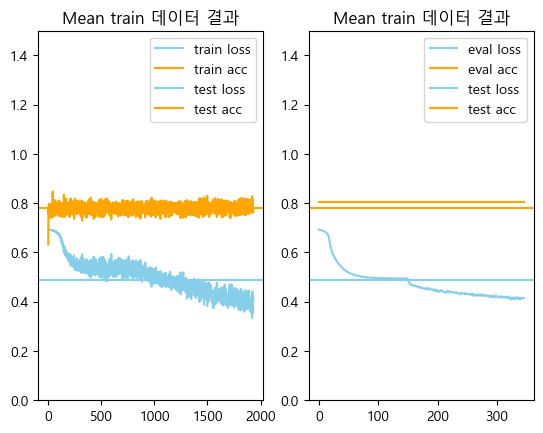

loss, 정확도 평가 중 ...

max 테스트 loss: 0.48780504
max 테스트 acc: 0.7791666666666667


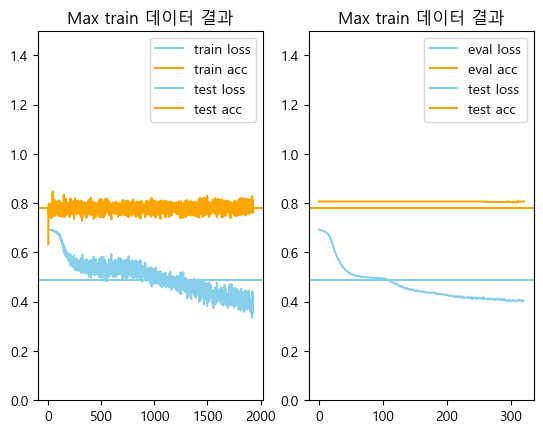

loss, 정확도 평가 중 ...

min 테스트 loss: 0.483626
min 테스트 acc: 0.7791666666666667


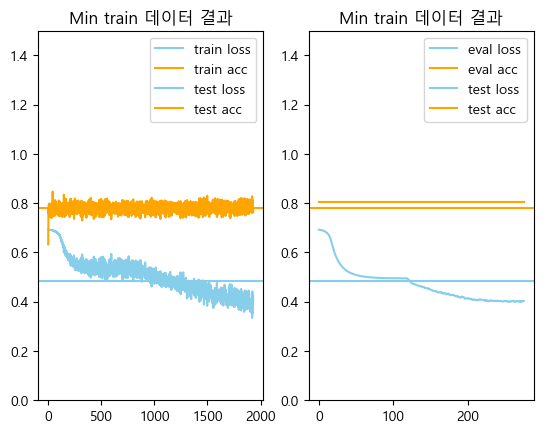

In [82]:
result7 = Result(trainer.acc_list, trainer.lost_list, eval_acc_list_7, eval_loss_list_7)
result7.save_result('PoolingRnnlm_result.pkl')
model_7.load_params('PooingSimpleRnnlm.pkl')
loss_test_7, acc_test_7 = eval_loss(model_7, corpus_test, label_test, batch_size, time_size)
print('mean 테스트 loss:', loss_test_7)
print('mean 테스트 acc:', acc_test_7)
result7.add_result(acc_test_7, loss_test_7)
result7.print_result('Mean')

result8 = Result(trainer.acc_list, trainer.lost_list, eval_acc_list_8, eval_loss_list_8)
result8.save_result('PoolingRnnlm2_result.pkl')
model_8.load_params('PooingSimpleRnnlm2.pkl')
loss_test_8, acc_test_8 = eval_loss(model_8, corpus_test, label_test, batch_size, time_size)
print('max 테스트 loss:', loss_test_8)
print('max 테스트 acc:', acc_test_8)
result8.add_result(acc_test_8, loss_test_8)
result8.print_result('Max')

result9 = Result(trainer.acc_list, trainer.lost_list, eval_acc_list_9, eval_loss_list_9)
result9.save_result('PoolingRnnlm3_result.pkl')
model_9.load_params('PooingSimpleRnnlm3.pkl')
loss_test_9, acc_test_9 = eval_loss(model_9, corpus_test, label_test, batch_size, time_size)
print('min 테스트 loss:', loss_test_9)
print('min 테스트 acc:', acc_test_9)
result9.add_result(acc_test_9, loss_test_9)
result9.print_result('Min')

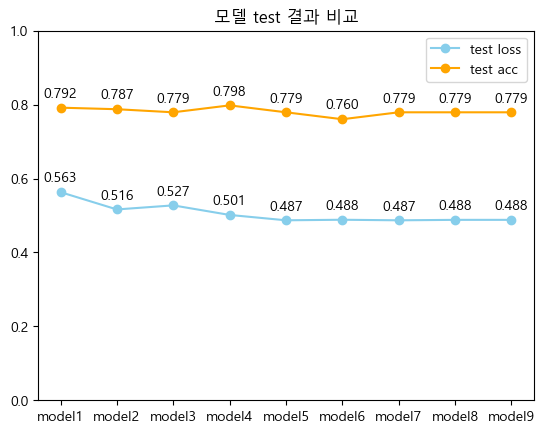

In [ ]:
test_loss_list = np.append(test_loss_list, [loss_test_7, loss_test_8, loss_test_8])
test_acc_list = np.append(test_acc_list, [acc_test_7, acc_test_8, acc_test_9])
index = np.arange(len(test_acc_list))

plt.plot(test_loss_list, color = 'skyblue', label = 'test loss', marker='o')
plt.plot(test_acc_list, color = 'orange', label = 'test acc', marker='o')
plt.legend()
plt.ylim(0, 1)
plt.xticks(index, ['model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7', 'model8', 'model9'])
plt.title('모델 test 결과 비교')

for i in index:
    plt.text(index[i], test_loss_list[i]+0.02, '%.3f' %test_loss_list[i], ha='center', va='bottom')
    plt.text(index[i], test_acc_list[i]+0.02, '%.3f' %test_acc_list[i], ha='center', va='bottom')
plt.show()

In [87]:
eval_loss_list_10 = []
eval_acc_list_10 = []

batch_size = 32      # 한 번에 학습 할 아동의 수
max_epoch = 400
max_grad = 0.25
wordvec_size = 32    # 단어의 벡터표현 크기
hidden_size = 16    # 문장의 표현 크기
time_size = 48       # 한 번에 읽을 단어 길이
lr = 0.00005
dropout = 0.5

model_10 = PoolingSimpleRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = Adam(lr)
trainer = PoolingRnnlmTrainer(model_10, optimizer, 'mean')

start_time = time.time()
best_loss = float('inf')
count = 0
patience = 20

for epoch in range(max_epoch):

    trainer.fit(corpus_train, label_train, time_size=time_size, hidden_size=hidden_size, max_epoch=1,
                 batch_size=batch_size, max_grad=max_grad, eval_interval=20)
    model_10.reset_state()
    avg_loss, avg_acc = eval_loss(model_10, corpus_val, label_val, batch_size=batch_size, time_size=time_size)
    
    eval_loss_list_10.append(avg_loss)
    eval_acc_list_10.append(avg_acc)
        
    print('평균 loss:', avg_loss)
    print('평균 acc:', avg_acc)
    print('learning rate:', lr)

    # 과적합 발생시 early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        count = 0
        model_10.save_params('PooingSimpleRnnlm4.pkl')
    else:
        count += 1

    if count >= patience:
        print('******Early Stopping Triggered******')
        break

    model_10.reset_state()
    print('-' * 70)
print('총 학습시간: %d[s]'%(time.time()-start_time))

| 에폭 1 |  반복 20 / 140 | 시간 0[s] | loss 0.6930 | 정확도 0.7562
| 에폭 1 |  반복 40 / 140 | 시간 0[s] | loss 0.6927 | 정확도 0.7562
| 에폭 1 |  반복 60 / 140 | 시간 1[s] | loss 0.6923 | 정확도 0.7875
| 에폭 1 |  반복 80 / 140 | 시간 1[s] | loss 0.6918 | 정확도 0.7969
| 에폭 1 |  반복 100 / 140 | 시간 2[s] | loss 0.6915 | 정확도 0.7719
| 에폭 1 |  반복 120 / 140 | 시간 2[s] | loss 0.6907 | 정확도 0.8109
| 에폭 1 |  반복 140 / 140 | 시간 2[s] | loss 0.6905 | 정확도 0.7469
loss, 정확도 평가 중 ...

평균 loss: 0.6894616
평균 acc: 0.806640625
learning rate: 5e-05
----------------------------------------------------------------------
| 에폭 2 |  반복 20 / 140 | 시간 0[s] | loss 0.6896 | 정확도 0.7703
| 에폭 2 |  반복 40 / 140 | 시간 0[s] | loss 0.6882 | 정확도 0.7781
| 에폭 2 |  반복 60 / 140 | 시간 1[s] | loss 0.6867 | 정확도 0.7734
| 에폭 2 |  반복 80 / 140 | 시간 1[s] | loss 0.6840 | 정확도 0.8031
| 에폭 2 |  반복 100 / 140 | 시간 2[s] | loss 0.6826 | 정확도 0.7734
| 에폭 2 |  반복 120 / 140 | 시간 2[s] | loss 0.6796 | 정확도 0.7797
| 에폭 2 |  반복 140 / 140 | 시간 2[s] | loss 0.6757 | 정확도 0.7906
loss, 정확도 평가 중 ..

loss, 정확도 평가 중 ...

mean 테스트 loss: 0.47932774
mean 테스트 acc: 0.8041666666666667


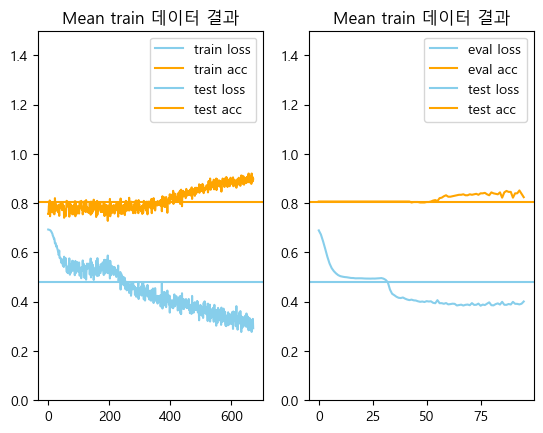

In [88]:
result10 = Result(trainer.acc_list, trainer.lost_list, eval_acc_list_10, eval_loss_list_10)
result10.save_result('PoolingRnnlm4_result.pkl')
model_10.load_params('PooingSimpleRnnlm4.pkl')
loss_test_10, acc_test_10 = eval_loss(model_10, corpus_test, label_test, batch_size, time_size)
print('mean 테스트 loss:', loss_test_10)
print('mean 테스트 acc:', acc_test_10)
result10.add_result(acc_test_10, loss_test_10)
result10.print_result('Mean')

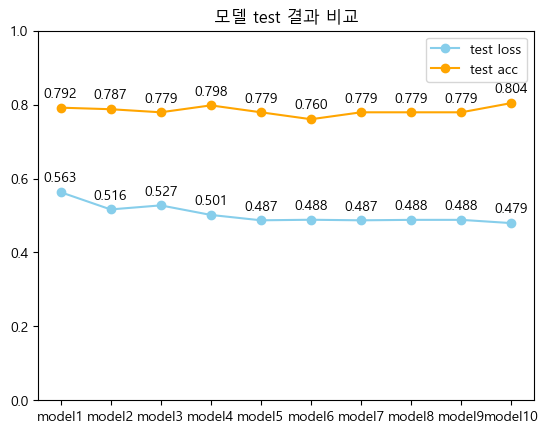

In [90]:
test_loss_list = np.append(test_loss_list, loss_test_10)
test_acc_list = np.append(test_acc_list, acc_test_10)
index = np.arange(len(test_acc_list))

plt.plot(test_loss_list, color = 'skyblue', label = 'test loss', marker='o')
plt.plot(test_acc_list, color = 'orange', label = 'test acc', marker='o')
plt.legend()
plt.ylim(0, 1)
plt.xticks(index, ['model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7', 'model8', 'model9', 'model10'])
plt.title('모델 test 결과 비교')

for i in index:
    plt.text(index[i], test_loss_list[i]+0.02, '%.3f' %test_loss_list[i], ha='center', va='bottom')
    plt.text(index[i], test_acc_list[i]+0.02, '%.3f' %test_acc_list[i], ha='center', va='bottom')
plt.show()